In [1]:
# Imports.
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

from data_utils import CSVData
from dynamical_systems import linear_system, andronov_hopf, vec_roessler_attractor
from nets import EulerN
from torch.utils.data import DataLoader
from utils import euler, plot_phase_portrait, plot_3d_trajectory, train_valid_loader

# 1. Linear system.

In [ ]:
# Choose your network parameters.
input_size=2
num_param=1
hidden_size=20
h=1

# Initialise the model.
model = EulerN(input_size, num_param, hidden_size, h)

In [ ]:
# Load data.
dataset = CSVData(csv_file_path='first_model.csv')
dataloader = DataLoader(dataset, batch_size=100, shuffle=True)

In [ ]:
# Loss & optimizer.
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.01)


for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, params, labels = data
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs, params)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.9f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

In [ ]:
alpha = 0.1

plot_phase_portrait(linear_system, alpha, model, 100)

# 2. Andronov-Hopf system

In [ ]:
h = 1

hss = [100, 128]
bss = [250]
lrs = [0.005, 0.001, 0.0005]
wds = [0.0]
nhls = [3, 4, 5]
epochs = 30


for bs in bss:
    dataset = CSVData(csv_file_path='second_model.csv')    
    train_loader, valid_loader = train_valid_loader(dataset, bs=bs)
    
    for hs in hss:
        for lr in lrs:
            for wd in wds:
                for nhl in nhls:
                    print('-----------------------------------------------------------')
                    print('bs=' + str(bs), 'hs=' + str(hs), 'lr=' + str(lr), 
                          'wd=' + str(wd), 'nhl=' + str(nhl))
                    model = EulerN(2, 1, hs, h, nhl)
                    criterion = nn.MSELoss()
                    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
                    
                    for epoch in range(epochs):  # loop over the dataset multiple times
                        running_loss = 0.0
                        for i, data in enumerate(train_loader, 0):
                            # get the inputs; data is a list of [inputs, labels]
                            inputs, params, labels = data
                            
                            # zero the parameter gradients
                            optimizer.zero_grad()

                            # forward + backward + optimize
                            outputs = model(inputs, params)
                            loss = criterion(outputs, labels)
                            loss.backward()
                            optimizer.step()

                            # print statistics
                            #running_loss += loss.item()
                            #if i % 200 == 199:    # print every 2000 mini-batches
                                #print('[%2d, %4d] loss: %.15f' %
                                        #(epoch + 1, i + 1, running_loss / 200))
                                #running_loss = 0.0
                                
                    print('Finished Training')
                        
                        
                    with torch.no_grad():
                        train_loss = 0.0
                        valid_loss = 0.0
                        criterion = nn.MSELoss()
                            
                        for data in train_loader:
                            inputs, params, labels = data
                            outputs = model(inputs, params)
                            loss = criterion(outputs, labels)
                            train_loss += loss.item()
                                                        
                        for data in valid_loader:
                            inputs, params, labels = data
                            outputs = model(inputs, params)
                            loss = criterion(outputs, labels)
                            valid_loss += loss.item()
                                
                        train_loss /= len(train_loader)
                        valid_loss /= len(valid_loader)
                                                        
                        print('Train loss: %.15f' % (train_loss,))
                        print('Valid loss: %.15f' % (valid_loss,))
                        
                        plot_phase_portrait(andronov_hopf, -1., model, 2)
                        plot_phase_portrait(andronov_hopf,  0., model, 2)
                        plot_phase_portrait(andronov_hopf,  1., model, 2)

In [ ]:
plot_phase_portrait(andronov_hopf, -1.0, model, 2)
plot_phase_portrait(andronov_hopf,  0.0, model, 2)
plot_phase_portrait(andronov_hopf,  1.0, model, 2)

# 3. Roessler attractor

-----------------------------------------------------------
bs=1000 hs=100 lr=0.1 wd=0.0 nhl=3
[ 1,  200] loss: 0.372014371966943
[ 1,  400] loss: 0.070693512819707
[ 1,  600] loss: 0.043874149819021
[ 1,  800] loss: 0.037679072050378
[ 1, 1000] loss: 0.057721184464172
[ 1, 1200] loss: 0.011663443783182
[ 1, 1400] loss: 0.097391473504249
[ 1, 1600] loss: 0.057429577654693
[ 1, 1800] loss: 0.012282214910956
[ 1, 2000] loss: 0.012191147786216
[ 1, 2200] loss: 0.026325591503992
[ 1, 2400] loss: 0.074579686683137
[ 1, 2600] loss: 0.030667097432306
[ 1, 2800] loss: 0.016992541478248
[ 1, 3000] loss: 0.009403637148207
[ 1, 3200] loss: 0.006164158563479
[ 1, 3400] loss: 0.016651359359385
[ 1, 3600] loss: 0.009469827919966
[ 1, 3800] loss: 0.005893369254773
[ 1, 4000] loss: 0.026110001338529
[ 1, 4200] loss: 0.249674034699565
[ 1, 4400] loss: 0.050560306152329
[ 1, 4600] loss: 0.026597056479659
[ 1, 4800] loss: 0.035818290702300
Finished Training
Train loss: 0.010937647091729
Valid loss: 0.011

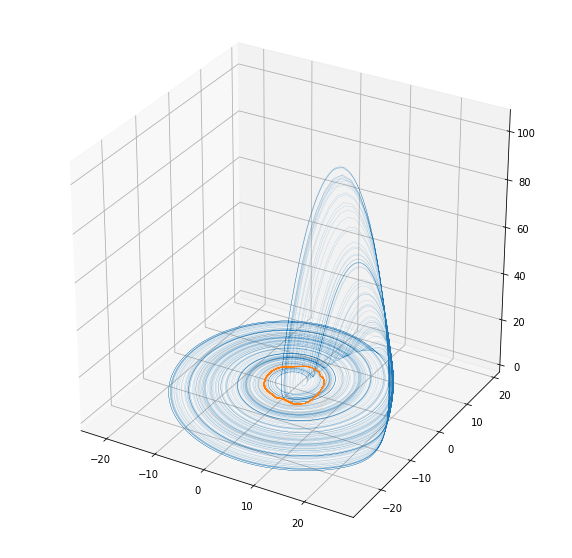

-----------------------------------------------------------
bs=1000 hs=100 lr=0.1 wd=0.0 nhl=5
[ 1,  200] loss: 0.176685461574234
[ 1,  400] loss: 0.028030429919600
[ 1,  600] loss: 0.049277640911750
[ 1,  800] loss: 0.008345458547701
[ 1, 1000] loss: 0.061986739186104
[ 1, 1200] loss: 0.027350092738634
[ 1, 1400] loss: 0.009637068746961
[ 1, 1600] loss: 0.016757904341794
[ 1, 1800] loss: 0.011529800941353
[ 1, 2000] loss: 0.003759265311819
[ 1, 2200] loss: 0.006224124358268
[ 1, 2400] loss: 0.021890280777588
[ 1, 2600] loss: 0.014134648843901
[ 1, 2800] loss: 0.017665185857913
[ 1, 3000] loss: 0.009699029543553
[ 1, 3200] loss: 0.017860974454670
[ 1, 3400] loss: 0.023447513179854
[ 1, 3600] loss: 0.018142749695107
[ 1, 3800] loss: 0.016175463236868
[ 1, 4000] loss: 0.007890210103360
[ 1, 4200] loss: 0.005299907700391
[ 1, 4400] loss: 0.003859271606780
[ 1, 4600] loss: 0.007933678895934
[ 1, 4800] loss: 0.011034084747953
Finished Training
Train loss: 0.001924597694815
Valid loss: 0.001

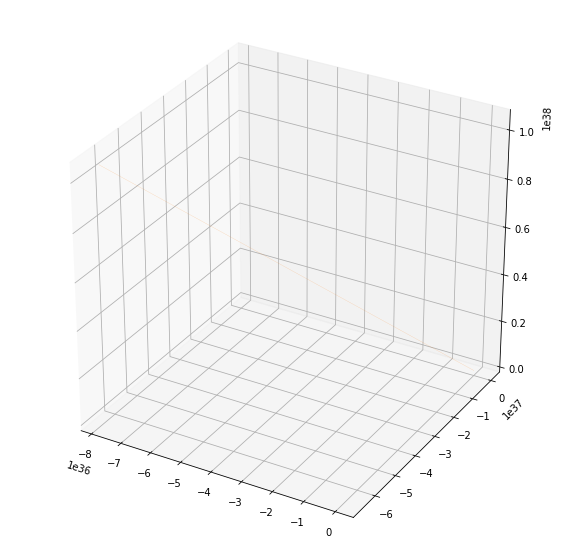

-----------------------------------------------------------
bs=1000 hs=100 lr=0.1 wd=0.1 nhl=3
[ 1,  200] loss: 0.602885311581194
[ 1,  400] loss: 0.585725920610130
[ 1,  600] loss: 0.636299201622605
[ 1,  800] loss: 0.605395249128342
[ 1, 1000] loss: 0.642620954439044
[ 1, 1200] loss: 0.615593606717885
[ 1, 1400] loss: 0.645587811917067
[ 1, 1600] loss: 0.614091053083539
[ 1, 1800] loss: 0.612758116461337
[ 1, 2000] loss: 0.591805074252188
[ 1, 2200] loss: 0.627424563094974
[ 1, 2400] loss: 0.615729604475200
[ 1, 2600] loss: 0.601857512891293
[ 1, 2800] loss: 0.604412768706679
[ 1, 3000] loss: 0.618399278298020
[ 1, 3200] loss: 0.660015893653035
[ 1, 3400] loss: 0.666085827574134
[ 1, 3600] loss: 0.671024287864566
[ 1, 3800] loss: 1.934529465399683
[ 1, 4000] loss: 0.666751942560077
[ 1, 4200] loss: 0.613548078835011
[ 1, 4400] loss: 0.604747589118779
[ 1, 4600] loss: 0.644040127955377
[ 1, 4800] loss: 0.636854215115309
Finished Training
Train loss: 0.702994755016019
Valid loss: 0.702

/home/ludwig/.local/lib/python3.6/site-packages/mpl_toolkits/mplot3d/proj3d.py:152: RuntimeWarning: invalid value encountered in true_divide
  txs, tys, tzs = vecw[0]/w, vecw[1]/w, vecw[2]/w


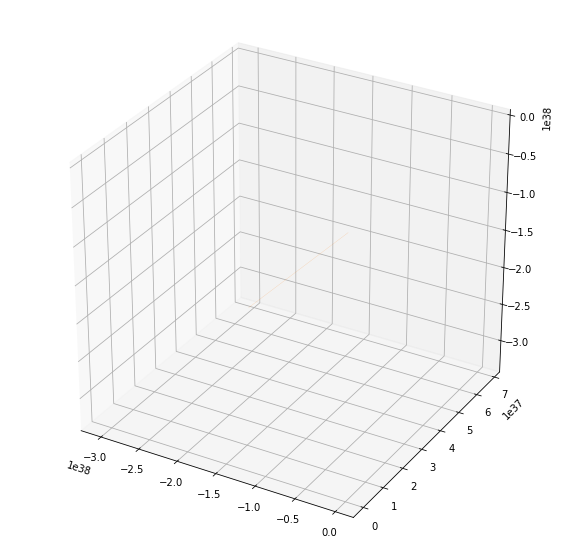

-----------------------------------------------------------
bs=1000 hs=100 lr=0.1 wd=0.1 nhl=5
[ 1,  200] loss: 0.645780482552946
[ 1,  400] loss: 0.648139525651932
[ 1,  600] loss: 0.650486763902009
[ 1,  800] loss: 0.663655476421118
[ 1, 1000] loss: 0.677152408957481
[ 1, 1200] loss: 0.660128859728575
[ 1, 1400] loss: 0.641502512097359
[ 1, 1600] loss: 0.655039115175605
[ 1, 1800] loss: 0.650575640052557


KeyboardInterrupt: 

In [2]:
h = 1

hss = [100, 200]
bss = [1000]
lrs = [0.1, 0.01, 0.001, 0.0001]
wds = [0.0, 0.1, 0.01]
nhls = [3, 5]
epochs = 1


for bs in bss:
    dataset = CSVData(csv_file_path='third_model.csv', input_size=3)   
    train_loader, valid_loader = train_valid_loader(dataset, bs=bs)
    for hs in hss:
        for lr in lrs:
            for wd in wds:
                for nhl in nhls:
                    print('-----------------------------------------------------------')
                    print('bs=' + str(bs), 'hs=' + str(hs), 'lr=' + str(lr), 
                          'wd=' + str(wd), 'nhl=' + str(nhl))
                    model = EulerN(3, 1, hs, h, nhl)
                    criterion = nn.MSELoss()
                    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
                    
                    for epoch in range(epochs):  # loop over the dataset multiple times
                        running_loss = 0.0
                        for i, data in enumerate(train_loader, 0):
                            # get the inputs; data is a list of [inputs, labels]
                            inputs, params, labels = data
                            
                            # zero the parameter gradients
                            optimizer.zero_grad()

                            # forward + backward + optimize
                            outputs = model(inputs, params)
                            loss = criterion(outputs, labels)
                            loss.backward()
                            optimizer.step()

                            # print statistics
                            running_loss += loss.item()
                            if i % 200 == 199:    # print every 200 mini-batches
                                print('[%2d, %4d] loss: %.15f' %
                                        (epoch + 1, i + 1, running_loss / 200))
                                running_loss = 0.0
                                
                    print('Finished Training')
                        
                        
                    with torch.no_grad():
                        train_loss = 0.0
                        valid_loss = 0.0
                        criterion = nn.MSELoss()
                            
                        for data in train_loader:
                            inputs, params, labels = data
                            outputs = model(inputs, params)
                            loss = criterion(outputs, labels)
                            train_loss += loss.item()
                                                        
                        for data in valid_loader:
                            inputs, params, labels = data
                            outputs = model(inputs, params)
                            loss = criterion(outputs, labels)
                            valid_loss += loss.item()
                                
                        train_loss /= len(train_loader)
                        valid_loss /= len(valid_loader)
                                                        
                        print('Train loss: %.15f' % (train_loss,))
                        print('Valid loss: %.15f' % (valid_loss,))
                        
                        plot_3d_trajectory(vec_roessler_attractor, 0.2, model, np.array([10,10,0]))

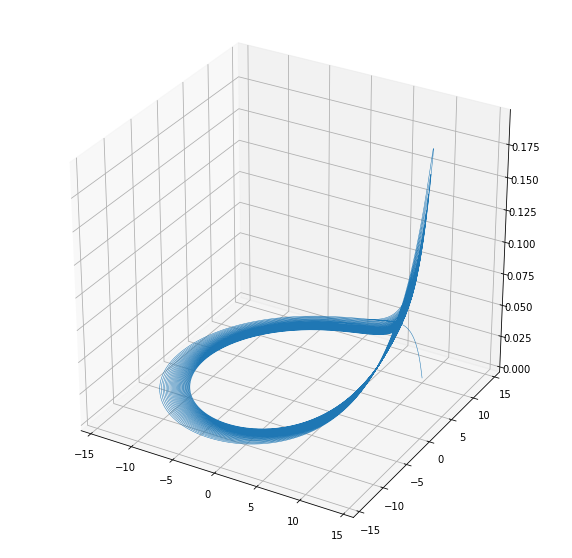

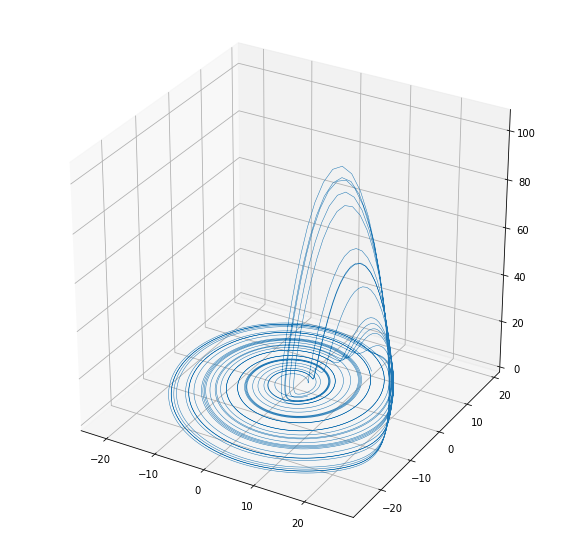

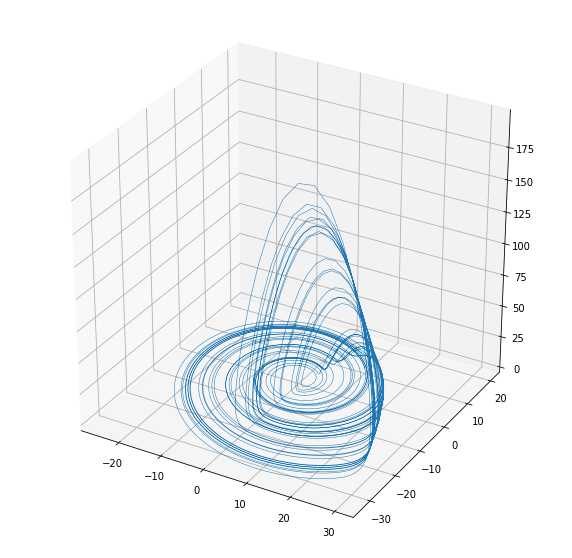

In [3]:
from scipy.integrate import solve_ivp
from mpl_toolkits.mplot3d import Axes3D


def plot_3d_trajectory(param, x0):
    tspan = (0., 200.)
    teval = np.arange(tspan[0], tspan[1], 0.02)
    sol = solve_ivp(lambda t, x: vec_roessler_attractor(x, param), tspan, x0, t_eval=teval)
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(sol.y[0], sol.y[1], sol.y[2], lw=0.5)
    plt.show()
    return

plot_3d_trajectory(0.0, np.array([10,10,0]))
plot_3d_trajectory(0.2, np.array([10,10,0]))
plot_3d_trajectory(0.3, np.array([10,10,0]))